In [1]:
# Connect to Azure Machine Learning Workspace
from azureml.core.workspace import Workspace

import pandas as pd
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_rows', 3000)
import numpy as np 
import datetime as dt 

import pyodbc
import copy 
import ibm_db_dbi as db

import datetime

In [2]:
# Freightwave Sonar
def get_data(server_name, db_name, query, trusted_conn=True, username='mlccm', password='WWS4VAySkR!gc2gCj_9u0J'):
    # if trusted_conn == True:
     #    cnxn = pyodbc.connect('DRIVER={/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.2.so.0.1};SERVER=' + server_name + ';DATABASE=' + db_name + ';Trusted_connection=yes')
    # else:
    # cnxn = pyodbc.connect('DRIVER={/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.2.so.0.1};SERVER=' + server_name + ';DATABASE=' + db_name + ';UID=' + username + ';PWD=' + password + '')
    cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + server_name + ';DATABASE=' + db_name + ';Trusted_connection=yes')
         #    cnxn = pyodbc.connect('DRIVER={/opt/microsoft/msodbcsql17/lib64/libmsodbcsql-17.2.so.0.1};SERVER=' + server_name + ';DATABASE=' + db_name + ';Trusted_connection=yes')

    data = pd.read_sql(query, cnxn)
    cnxn.close()
    return data

### Database Information ###

# Db2

# Brokerage Database Information
brokerage_host_name = 'oldb01'
brokerage_port_ID = '60018'
brokerage_db_name = 'dbtmsp'

# Data Warehouse Information
vasdw_host_name = 'edwdb1'
vasdw_port_ID = '60000'
vasdw_db_name = 'dbvasp'

# SQL Server

# LOGI_APP_ANALYTICS Information
logi_app_server_name = 'tcp:mssqldm01-a,59778'
dev_logi_app_server_name = 'tcp:mssqldev02-a,59778'
logi_app_db_name = 'LOGI_APP_ANALYTICS'

# BI Team Information
bi_server_name = 'tcp:mssqlbiza_01-a,59779'
bi_db_name = 'Analysis_staging'

# Example SQL Query
# haul_sonar_df = get_data(bi_server_name, bi_db_name, haul_sonar_query)

# Example DB2 Query
dat_zone_query = '''SELECT ZONE_ID AS ORIG_ZONE, STATE AS ORIG_STATE, COUNTRY AS ORIG_COUNTRY, 
ZONE_ID AS DEST_ZONE, STATE AS DEST_STATE, COUNTRY AS DEST_COUNTRY, 
ZONE_ID AS SHIP_ZONE, STATE AS SHIP_STATE, COUNTRY AS SHIP_COUNTRY
FROM ECP.DAT_ZONE_STATE_MAPPING;'''
# db2 = db.connect('DATABASE='+brokerage_db_name+';HOSTNAME='+brokerage_host_name+';PORT='+brokerage_port_ID+';PROTOCOL=TCPIP;UID=kismith;PWD=KIsMItH17926;')
# dat_zone_df  = pd.read_sql(dat_zone_query, db2)
# db2.close()

shipment_ids_string = ''

tours_query = """
SELECT csah.SEGMENT_NUMBER , csah.CREATED_BY , csah.CREATE_DATE , csah.USER_ID , CSAH.USER_ROLE, csah.ACTION,
csah.CARRIER_SCORE, CSAH.TOP_RANKED_CARRIER_SCORE, CSAH.BOTTOM_RANKED_CARRIER_SCORE, CSAH.CARRIER_RANK, CSAH.TOTAL_CARRIERS_RANKED,
D.SHIPMENT_ID, D.CLG_FG, D.RG_FG, D.ASSET_FG,
D.TOUR_STATUS_TX, D.CARRIER_NM, D.ECP_CARRIER_IDENT, D.STAKEHOLDER_ID, D.CARRIER_ASSIGNED_BY,
D.CARRIER_ASSIGNED_TS, D.LOAD_NEEDS_BROKERING_TS, D.TOTAL_CARRIER_ASSIGNMENTS, D.CARRIER_ASSIGNEE_GUID, 
D.ROUTING_GUIDE_ACTION_CREATE_TS, D.TENDER_STATUS_DESCRIPTION_TX
FROM LOGI_APP_ANALYTICS.dbo.CLG_SEGMENT_ACTION_HISTORY csah
FULL OUTER JOIN (
--SELECT *,
SELECT SHIPMENT_ID, CARRIER_NM, evsht.ECP_CARRIER_IDENT , evsht.STAKEHOLDER_ID,
TOUR_STATUS_TX, CARRIER_ASSIGNED_TS, LOAD_NEEDS_BROKERING_TS, TOTAL_CARRIER_ASSIGNMENTS,
CARRIER_ASSIGNED_BY, CARRIER_ASSIGNEE_GUID,
vrgs.ROUTING_GUIDE_ACTION_CREATE_TS, vrgs.TENDER_STATUS_DESCRIPTION_TX, 
(case when upper(CARRIER_ASSIGNED_BY) <> CARRIER_ASSIGNED_BY
    and LTRIM( Rtrim(CARRIER_ASSIGNED_BY)) <> 'jboss'
    and LTRIM( Rtrim(CARRIER_ASSIGNED_BY)) <> 'MTier'
    and LTRIM( Rtrim(CARRIER_ASSIGNED_BY)) <> 'wlsedi'
    and LTRIM( Rtrim(CARRIER_ASSIGNED_BY)) <> 'svrcflp' then 1 else 0 end) as CLG_FG,
(CASE WHEN SHIPMENT_ID = VRGS.SOURCE_SYSTEM_IDENT_ID  THEN 1 ELSE 0 END) as RG_FG,
(CASE WHEN CARRIER_NM  = 'WERNER ENTERPRISES, INC' THEN 1 ELSE 0 END) as ASSET_FG
FROM LOGI_APP_ANALYTICS.dbo.ECP_VASDW_SHIPMENT_HISTORY_TOUR evsht
LEFT JOIN (select rs.*
from LOGI_APP_ANALYTICS.dbo.VASDW_ROUTING_GUIDE_SHIPMENT rs 
where rs.ROUTING_GUIDE_ACTION_CREATE_TS = (select max(rs2.ROUTING_GUIDE_ACTION_CREATE_TS) from 
                      LOGI_APP_ANALYTICS.dbo.VASDW_ROUTING_GUIDE_SHIPMENT rs2
                      where rs.SOURCE_SYSTEM_IDENT_ID = rs2.SOURCE_SYSTEM_IDENT_ID 
                      and TENDER_STATUS_DESCRIPTION_TX = 'Accepted'
                     )
) vrgs ON (vrgs.SOURCE_SYSTEM_IDENT_ID = evsht.SHIPMENT_ID )
--where SOURCE_SYSTEM_IDENT_ID is not null 
--and TENDER_STATUS_DESCRIPTION_TX = 'Accepted'
) AS D ON (D.SHIPMENT_ID = csah.SEGMENT_NUMBER )
--where csah.[ACTION] = 'CARRIER_ASSIGNMENT'
--WHERE D.SHIPMENT_NUMBER NOT IN ({})
;
""".format(shipment_ids_string)

tour_events_query = """SELECT FROM_ID , CREATE_TS , CREATE_USER_CD FROM VASDW.MISC_EVENT me 
WHERE TYPE_ID = 1852
AND FROM_CLASS_ID = 32
AND CREATE_TS >= '2018-04-20 15:34:29'
AND FROM_ID IN ({})
;""".format(shipment_ids_string)

In [3]:
schedule = 'previous week'
# schedule = 'previous rolling week'
# schedule = 'previous month'
# schedule = 'previous rolling month'
# schedule = 'previous rolling year'

today = datetime.date.today()

now = today

firstOfThisMonth = now.replace(day=1)

endOfLastMonth = firstOfThisMonth-datetime.timedelta(days=1)

firstOfLastMonth = endOfLastMonth.replace(day=1)

if schedule == 'previous week':
    start_date_time = today + datetime.timedelta(days=-today.weekday(), weeks= -1)
    end_date_time = today + datetime.timedelta(days=-today.weekday(), weeks= 0)
if schedule == 'previous rolling week':
    start_date_time = today + datetime.timedelta(weeks= -1)
    end_date_time = today
if schedule == 'previous month':
    start_date_time = firstOfLastMonth
    end_date_time = firstOfThisMonth
if schedule == 'previous rolling month':
    start_date_time = today + datetime.timedelta(days = -30)
    end_date_time = today
if schedule == 'previous rolling year':
    start_date_time = today + datetime.timedelta(days = -365)
    end_date_time = today 
    
print(start_date_time)
print(end_date_time)

2021-02-15
2021-02-22


In [4]:
# LOOK AT THIS LATER Only need to query new data .. need to figure out how to mark records that are new vs not new ... 

import time 

total_start_time = time.time()

start = time.time() 


       
new_tours = get_data(logi_app_server_name, logi_app_db_name, tours_query)
new_tours['CREATE_DATE'] = pd.to_datetime(new_tours['CREATE_DATE'])
new_tours['CARRIER_ASSIGNED_TS'] = pd.to_datetime(new_tours['CARRIER_ASSIGNED_TS'])
new_tours['LOAD_NEEDS_BROKERING_TS'] = pd.to_datetime(new_tours['LOAD_NEEDS_BROKERING_TS'])
new_tours['ROUTING_GUIDE_ACTION_CREATE_TS'] = pd.to_datetime(new_tours['ROUTING_GUIDE_ACTION_CREATE_TS'])

previous_tours = pd.DataFrame()
    
# else:
#     tours = pd.read_csv('tour_12_31.csv', parse_dates = ['CREATE_DATE', 'CARRIER_ASSIGNED_TS', 'LOAD_NEEDS_BROKERING_TS', 'ROUTING_GUIDE_ACTION_CREATE_TS'])
#     tour_events = pd.read_csv('tour_events_12_31_redo.csv', parse_dates = ['CREATE_TS'])

end = time.time()

In [5]:
# get rid of rows with duplicate rows 
tours_columns = new_tours.columns.values
tours = pd.concat([previous_tours, new_tours], axis=0)
tours = tours.drop_duplicates(subset = tours_columns)

In [6]:
# Tours Data Transformations

tours = tours.dropna(subset= ['CARRIER_ASSIGNED_TS'])

# Drop tours from CLG which are not assignments 
tours = tours[~tours.ACTION.isin(['ADD_REJECTION', 'ADD_BID', 'CARRIER_REMOVE', 'REPLACE_BID', 'POST_ASSET',
                                'DELETE_ASSET', 'REVERT_REJECTION', 'EXPIRED_ASSET'])]

# Drop tours which were moved by intermodal or Werner Asset
tours = tours[~tours.CARRIER_NM.str.lower().str.contains('intermodal')]
tours = tours[~tours.CARRIER_NM.str.lower().str.contains('werner')]

# Assign CLG flag for tours where CREATED BY matches CARRIER_ASSIGNED_BY
tours['CLG_FG'] = np.where((tours['CREATED_BY'].str[0:5] == tours['CARRIER_ASSIGNED_BY'].str[0:5]), 1, 0)

# Turn to datetimes 
tours['CREATE_DATE'] = pd.to_datetime(tours['CREATE_DATE'])
tours['CARRIER_ASSIGNED_TS'] = pd.to_datetime(tours['CARRIER_ASSIGNED_TS'])
tours['LOAD_NEEDS_BROKERING_TS'] = pd.to_datetime(tours['LOAD_NEEDS_BROKERING_TS'])
tours['ROUTING_GUIDE_ACTION_CREATE_TS'] = pd.to_datetime(tours['ROUTING_GUIDE_ACTION_CREATE_TS'])

tours['MONTH'] = tours['CARRIER_ASSIGNED_TS'].dt.month
tours['YEAR'] = tours['CARRIER_ASSIGNED_TS'].dt.year

# Calculate lead time 
tours['LEAD_TIME'] = ((tours['CARRIER_ASSIGNED_TS'] - tours['LOAD_NEEDS_BROKERING_TS']).dt.total_seconds() / (60 * 60))

# Calculate the time difference between TOUR CREATION in CLG and RG
tours['TIME_DIFF_CLG'] = (tours['CARRIER_ASSIGNED_TS'] - tours['CREATE_DATE']).dt.total_seconds() 
tours['TIME_DIFF_RG'] = (tours['CARRIER_ASSIGNED_TS'] - tours['ROUTING_GUIDE_ACTION_CREATE_TS']).dt.total_seconds() 

# make sure every tour has a shipment ID 
tours['ACTUAL_SHIPMENT_ID'] = tours['SEGMENT_NUMBER'].fillna(tours['SHIPMENT_ID'])

# make sure every tour uses the most recent action for the CARRIER_ASSIGNED_TS
tours['ACTUAL_CARRIER_ASSIGNED_TS'] = tours[['CREATE_DATE', 'ROUTING_GUIDE_ACTION_CREATE_TS', 'CARRIER_ASSIGNED_TS']].max(axis = 1)

# find time difference between most recent action and assigned ts we have in SMART 
tours['ACTUAL_TIME_DIFF'] = (tours['CARRIER_ASSIGNED_TS'] - tours['ACTUAL_CARRIER_ASSIGNED_TS']).dt.total_seconds() 

tours = tours[tours['ACTUAL_CARRIER_ASSIGNED_TS']>='2018-04-20 15:34:29']

tours['TIME_DIFF_CLG'] = pd.to_numeric(tours['TIME_DIFF_CLG'])
tours['TIME_DIFF_RG'] = pd.to_numeric(tours['TIME_DIFF_RG'])
tours['LEAD_TIME'] = pd.to_numeric(tours['LEAD_TIME'])
tours['CARRIER_RANK'] = pd.to_numeric(tours['CARRIER_RANK'])

# HOW CAN I SPEED THIS UP 
tours = tours.dropna(subset= ['ACTUAL_CARRIER_ASSIGNED_TS'])
tours['ACTUAL_CARRIER_ASSIGNED_TS'] = pd.to_datetime(tours['ACTUAL_CARRIER_ASSIGNED_TS'])

tours =  tours[(tours.ACTUAL_CARRIER_ASSIGNED_TS >= pd.to_datetime(start_date_time)) & (tours.ACTUAL_CARRIER_ASSIGNED_TS < pd.to_datetime(end_date_time)) ]

# Query Tour Events based on unique Tours
start = time.time()

shipment_ids = np.array_split(tours['ACTUAL_SHIPMENT_ID'].unique().astype(str), 9)
shipment_id_strings = [', '.join(item) for item in shipment_ids]

new_tour_events = pd.DataFrame()

for i in shipment_id_strings: 
    tour_events_query = '''SELECT FROM_ID , CREATE_TS , CREATE_USER_CD FROM VASDW.MISC_EVENT me 
            WHERE TYPE_ID = 1852
            AND FROM_CLASS_ID = 32
            AND FROM_ID IN ({})
            ;'''.format(i)
    db2 = db.connect('DATABASE='+ vasdw_db_name+';HOSTNAME='+ vasdw_host_name+';PORT='+ vasdw_port_ID+';PROTOCOL=TCPIP;UID=kismith;PWD=kismith23784;')
    tour_events_string  = pd.read_sql(tour_events_query, db2)
    new_tour_events = new_tour_events.append(tour_events_string)
    db2.close()

# db2 = db.connect('DATABASE='+ vasdw_db_name+';HOSTNAME='+ vasdw_host_name+';PORT='+ vasdw_port_ID+';PROTOCOL=TCPIP;UID=kismith;PWD=kismith23784;')
# new_tour_events  = pd.read_sql(tour_events_query, db2)
# db2.close()
 
new_tour_events['CREATE_TS'] = pd.to_datetime(new_tour_events['CREATE_TS'])

tour_events_columns = new_tour_events.columns.values
# if no previous datafframe need this intanstiated 
previous_tour_events = pd.DataFrame()
tour_events = pd.concat([previous_tour_events, new_tour_events], axis=0)
tour_events = tour_events.drop_duplicates(subset = tour_events_columns).reset_index(drop = True)

# Query Tour Events based on unique Tours
start = time.time()

shipment_ids = np.array_split(tours['ACTUAL_SHIPMENT_ID'].unique().astype(str), 9)
shipment_id_strings = [', '.join(item) for item in shipment_ids]

new_tour_events = pd.DataFrame()

for i in shipment_id_strings: 
    tour_events_query = '''SELECT FROM_ID , CREATE_TS , CREATE_USER_CD FROM VASDW.MISC_EVENT me 
            WHERE TYPE_ID = 1852
            AND FROM_CLASS_ID = 32
            AND FROM_ID IN ({})
            ;'''.format(i)
    db2 = db.connect('DATABASE='+ vasdw_db_name+';HOSTNAME='+ vasdw_host_name+';PORT='+ vasdw_port_ID+';PROTOCOL=TCPIP;UID=kismith;PWD=kismith23784;')
    tour_events_string  = pd.read_sql(tour_events_query, db2)
    new_tour_events = new_tour_events.append(tour_events_string)
    db2.close()

# db2 = db.connect('DATABASE='+ vasdw_db_name+';HOSTNAME='+ vasdw_host_name+';PORT='+ vasdw_port_ID+';PROTOCOL=TCPIP;UID=kismith;PWD=kismith23784;')
# new_tour_events  = pd.read_sql(tour_events_query, db2)
# db2.close()
 
new_tour_events['CREATE_TS'] = pd.to_datetime(new_tour_events['CREATE_TS'])

tour_events_columns = new_tour_events.columns.values
# if no previous datafframe need this intanstiated 
previous_tour_events = pd.DataFrame()
tour_events = pd.concat([previous_tour_events, new_tour_events], axis=0)
tour_events = tour_events.drop_duplicates(subset = tour_events_columns).reset_index(drop = True)

# 281 seconds total 
total_end_time = time.time()

print(total_end_time - total_start_time)

105.6281316280365


In [7]:
tours.to_csv('current_tours.csv')
tour_events.to_csv('current_tour_events.csv')

In [8]:
# Put your workspace credentials here 
ws = Workspace(workspace_name = 'cde-mlw-cus-kim-01',
subscription_id = '33ade888-a732-4771-84c6-bccff4b8a974',
resource_group = 'cde-rg-cus-ds-01')

default_ds = ws.get_default_datastore()



default_ds.upload_files(files=['current_tours.csv', 'current_tour_events.csv'], # Upload the diabetes csv files in /data
                       target_path='tour-data-subset/', # Put it in a folder path in the datastore
                       overwrite=True, # Replace existing files of the same name
                       show_progress=True)

Uploading an estimated of 2 files
Uploading current_tour_events.csv
Uploaded current_tour_events.csv, 1 files out of an estimated total of 2
Uploading current_tours.csv
Uploaded current_tours.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_21e4c842f2aa4007b9b85d85914cc1a0

In [9]:
tours_2 = pd.read_csv('current_tours.csv')
tours_2.describe(include = 'all')

,Unnamed: 0,SEGMENT_NUMBER,CREATED_BY,CREATE_DATE,USER_ID,USER_ROLE,ACTION,CARRIER_SCORE,TOP_RANKED_CARRIER_SCORE,BOTTOM_RANKED_CARRIER_SCORE,CARRIER_RANK,TOTAL_CARRIERS_RANKED,SHIPMENT_ID,CLG_FG,RG_FG,ASSET_FG,TOUR_STATUS_TX,CARRIER_NM,ECP_CARRIER_IDENT,STAKEHOLDER_ID,CARRIER_ASSIGNED_BY,CARRIER_ASSIGNED_TS,LOAD_NEEDS_BROKERING_TS,TOTAL_CARRIER_ASSIGNMENTS,CARRIER_ASSIGNEE_GUID,ROUTING_GUIDE_ACTION_CREATE_TS,TENDER_STATUS_DESCRIPTION_TX,MONTH,YEAR,LEAD_TIME,TIME_DIFF_CLG,TIME_DIFF_RG,ACTUAL_SHIPMENT_ID,ACTUAL_CARRIER_ASSIGNED_TS,ACTUAL_TIME_DIFF
count,2.199000e+03,1.317000e+03,1317,1317,1317,1081,1317,830.000000,1303.000000,1303.000000,830.000000,1303.000000,2.199000e+03,2199.000000,2199.000000,2199.0,2199,2199,2.196000e+03,2.199000e+03,2199,2199,1214,2199.000000,1955,228,228,2199.0,2199.0,1214.000000,1.317000e+03,2.280000e+02,2.199000e+03,2199,2199.000000
unique,NaN,NaN,55,1317,55,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,697,NaN,NaN,95,2076,1107,NaN,74,228,1,NaN,NaN,NaN,NaN,NaN,NaN,2156,NaN
top,NaN,NaN,"Baker, Gregory",2021-02-16 14:24:10.467,4109631a-e716-4c99-980b-7a87f92197b6,CLG-EXP-2,CARRIER_ASSIGNMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Completed (Delivered),AC TRUCKING,NaN,NaN,jboss,2021-02-17 09:08:59.000,2021-02-18 09:53:25.000,NaN,4109631A-E716-4C99-980B-7A87F92197B6,2021-02-15 09:31:29.349,Accepted,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-15 12:53:21.000,NaN
freq,NaN,NaN,146,1,146,1081,1317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2170,87,NaN,NaN,211,3,3,NaN,158,1,228,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
mean,1.006665e+06,1.658248e+07,NaN,NaN,NaN,NaN,NaN,9.208592,9.331349,8.080655,12.790361,101.485802,1.658482e+07,0.557071,0.103683,0.0,NaN,NaN,1.000232e+08,1.714123e+06,NaN,NaN,NaN,1.449750,NaN,NaN,NaN,2.0,2021.0,55.749183,7.833571e+04,6.800328e+04,1.658482e+07,NaN,-5.586820
std,6.014124e+03,2.679260e+04,NaN,NaN,NaN,NaN,NaN,0.336408,0.236079,0.234853,28.877670,100.344673,2.152962e+04,0.496845,0.304919,0.0,NaN,NaN,1.909771e+04,5.700474e+05,NaN,NaN,NaN,0.987685,NaN,NaN,NaN,0.0,0.0,325.369148,1.108880e+06,2.780586e+05,2.152962e+04,NaN,9.244766
min,7.562250e+05,1.575685e+07,NaN,NaN,NaN,NaN,NaN,7.472600,7.968700,7.393500,1.000000,1.000000,1.575685e+07,0.000000,0.000000,0.0,NaN,NaN,1.000000e+08,2.716000e+03,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,-2.375833,-1.494460e+02,-6.900000e-01,1.575685e+07,NaN,-149.446000
25%,1.006390e+06,1.657809e+07,NaN,NaN,NaN,NaN,NaN,9.131150,9.336550,7.986000,1.000000,31.000000,1.658129e+07,0.000000,0.000000,0.0,NaN,NaN,1.000052e+08,1.745541e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,0.838819,-1.362600e+01,1.405000e-01,1.658129e+07,NaN,-11.588000
50%,1.007438e+06,1.658587e+07,NaN,NaN,NaN,NaN,NaN,9.373550,9.410700,8.035100,3.000000,68.000000,1.658785e+07,1.000000,0.000000,0.0,NaN,NaN,1.000179e+08,1.955427e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,2.234306,-1.063700e+01,9.110000e-01,1.658785e+07,NaN,0.000000
75%,1.008192e+06,1.659148e+07,NaN,NaN,NaN,NaN,NaN,9.440500,9.445400,8.236500,7.000000,135.000000,1.659211e+07,1.000000,0.000000,0.0,NaN,NaN,1.000412e+08,2.057447e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,49.950556,3.585956e+03,3.599718e+03,1.659211e+07,NaN,0.000000


In [10]:
# Put your workspace credentials here 
ws = Workspace(workspace_name = 'cde-mlw-cus-kim-01',
subscription_id = '33ade888-a732-4771-84c6-bccff4b8a974',
resource_group = 'cde-rg-cus-ds-01')

In [11]:
%%writefile data_transformations.py
# Import libraries
import os
import argparse
from azureml.core import Run, Dataset
import pandas as pd
import numpy as np
import joblib
import time 
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import roc_curve

def load_rebookings (tours, all_tours):
    rebooking_df = pd.DataFrame(columns = ['FROM_ID', 'ORIGINAL_SYSTEM', 'ORIGINAL_BOOKING_DATE', 
                                           'FINAL_SYSTEM', 'FINAL_BOOKING_DATE',
                                           'CLG_REBOOKINGS', 
                                           'SMART_REBOOKINGS', 'RG_REBOOKINGS', 'TOTAL_REBOOKINGS'])
    shipment_ids = tours['FROM_ID'].unique()
    for i in shipment_ids: 
        shipment_tours = all_tours[all_tours.FROM_ID == i].sort_values('CREATE_TS')
        original_system = shipment_tours.head(1)['SYSTEM'].values
        original_booking_date = shipment_tours.head(1)['CREATE_TS'].values
        final_system = shipment_tours.tail(1)['SYSTEM'].values
        final_booking_date = shipment_tours.tail(1)['CREATE_TS'].values
        clg_rebookings = len(shipment_tours[shipment_tours.SYSTEM == 'CLG'])
        smart_rebookings = len(shipment_tours[shipment_tours.SYSTEM == 'SMART'])
        rg_rebookings = len(shipment_tours[shipment_tours.SYSTEM == 'RG'])
        total_rebookings = clg_rebookings + smart_rebookings + rg_rebookings
        """
        if original_system == 'CLG': 
            clg_rebookings = clg_rebookings - 1
        if original_system == 'SMART': 
            smart_rebookings = smart_rebookings - 1
        if original_system == 'RG': 
            rg_rebookings = rg_rebookings - 1
        """
        new_row = {'FROM_ID': i, 'ORIGINAL_SYSTEM': original_system, 'ORIGINAL_BOOKING_DATE': original_booking_date,
                   'FINAL_SYSTEM': final_system, 'FINAL_BOOKING_DATE': final_booking_date,
                   'CLG_REBOOKINGS': clg_rebookings, 'SMART_REBOOKINGS': smart_rebookings, 
                   'RG_REBOOKINGS': rg_rebookings, 'TOTAL_REBOOKINGS': total_rebookings}
        rebooking_df = rebooking_df.append(new_row, ignore_index = True)
    return rebooking_df

script_start = time.time()

# Get the script arguments (regularization rate and training dataset ID)
parser = argparse.ArgumentParser()
# parser.add_argument('--regularization', type=float, dest='reg_rate', default=0.01, help='regularization rate')
parser.add_argument("--tours-ds", type=str, dest='training_dataset_id', help='training dataset')
parser.add_argument("--tour-events-ds", type=str, dest='training_dataset_id', help='training dataset')
args = parser.parse_args()

# Set regularization hyperparameter (passed as an argument to the script)
# reg = args.reg_rate

# Get the experiment run context
run = Run.get_context()

# Get the training dataset
print("Loading Data...")
tours = run.input_datasets['tours_data_set'].to_pandas_dataframe()
tour_events = run.input_datasets['tour_events_data_set'].to_pandas_dataframe()

run.log('dataset_length', len(tours))

tours_start_time = time.time()

tours['SYSTEM'] = ''

# Calculate System for all tours
for index, row in tours.iterrows(): 
#     if (pd.isnull(row['SYSTEM'])):
    if (row['SYSTEM'] == ''):  
        if (row['CARRIER_ASSIGNED_BY'].isupper()):
            tours.at[index, 'SYSTEM'] = 'SMART'
        if ((not row['CARRIER_ASSIGNED_BY'].isupper()) | (row['CARRIER_ASSIGNED_BY'].find(',') != -1)):
            tours.at[index, 'SYSTEM'] = 'CLG'
        if ((row['CARRIER_ASSIGNED_BY'].strip() == 'jboss')):
            tours.at[index, 'SYSTEM'] = 'RG'

tours['ACTUAL_CARRIER_ASSIGNED_TS'] = pd.to_datetime(tours['ACTUAL_CARRIER_ASSIGNED_TS'])
tours = tours.dropna(subset= ['ACTUAL_CARRIER_ASSIGNED_TS'])

# only take tours from april 2018 forward
tours = tours[tours['ACTUAL_CARRIER_ASSIGNED_TS']>='2018-04-20 15:34:29']

tours = tours.loc[tours.groupby('ACTUAL_SHIPMENT_ID').ACTUAL_CARRIER_ASSIGNED_TS.idxmax(skipna = True)]

tours_end_time = time.time()

run.log('tours_runtime', tours_end_time - tours_start_time)

tour_events_start_time = time.time()

tour_events['SYSTEM'] = ''

for index, row in tour_events.iterrows(): 
#    if (pd.isnull(row['SYSTEM_3'])):  
    if (row['SYSTEM'] == ''):  
        if (row['CREATE_USER_CD'].isupper()):
            tour_events.at[index, 'SYSTEM'] = 'SMART'
        if ((not row['CREATE_USER_CD'].isupper()) | (row['CREATE_USER_CD'].find(',') != -1)):
            tour_events.at[index, 'SYSTEM'] = 'CLG'
        if ((row['CREATE_USER_CD'].strip() == 'jboss')):
            tour_events.at[index, 'SYSTEM'] = 'RG'

tour_events_end_time = time.time()

run.log('tour_events_runtime', tour_events_end_time - tour_events_start_time)            

first_last_tour_events_start_time = time.time()

first_tour_events = tour_events.loc[tour_events.groupby('FROM_ID').CREATE_TS.idxmin(skipna = True)]

last_tour_events = tour_events.loc[tour_events.groupby('FROM_ID').CREATE_TS.idxmax(skipna = True)]

first_last_tour_events_end_time = time.time()

run.log('first_last_tour_events_runtime', first_last_tour_events_end_time - first_last_tour_events_start_time)     

# note file saved in the outputs folder is automatically uploaded into experiment record
tours.to_csv('outputs/processed_current_tours.csv', index = False)
tour_events.to_csv('outputs/processed_current_tour_events.csv', index = False)
first_tour_events.to_csv('outputs/processed_current_first_tour_events.csv', index = False)
last_tour_events.to_csv('outputs/processed_current_last_tour_events.csv', index = False)


tour_rebookings_start_time = time.time()

load_rebookings_split = np.array_split(tour_events, 59)

tour_rebookings = pd.DataFrame()

counter = 0

for i in load_rebookings_split: 
    counter = counter + 1
    tour_rebookings_chunk = load_rebookings(i, tour_events)
    tour_rebookings = tour_rebookings.append(tour_rebookings_chunk)
    end = time.time()
    
tour_rebookings = tour_rebookings.reset_index(drop = True)
tour_rebookings['ORIGINAL_BOOKING_DATE'] = tour_rebookings.apply(lambda row : row['ORIGINAL_BOOKING_DATE'][0], axis = 1)
tour_rebookings['ORIGINAL_SYSTEM'] = tour_rebookings.apply(lambda row : row['ORIGINAL_SYSTEM'][0], axis = 1)
tour_rebookings['FINAL_BOOKING_DATE'] = tour_rebookings.apply(lambda row : row['FINAL_BOOKING_DATE'][0], axis = 1)
tour_rebookings['FINAL_SYSTEM'] = tour_rebookings.apply(lambda row : row['FINAL_SYSTEM'][0], axis = 1)

tour_rebookings = tour_rebookings.drop_duplicates(ignore_index = True )
tour_rebookings.columns = ['SHIPMENT_ID', 'ORIGINAL_SYSTEM', 'ORIGINAL_DATE_ASSIGNED',
                                       'FINAL_SYSTEM', 'FINAL_DATE_ASSIGNED',
                                         'CLG_REBOOKINGS', 'SMART_REBOOKINGS', 'RG_REBOOKINGS',
                                         'TOTAL_REBOOKINGS']

# CAN CHANGE THIS HERE 
tour_rebookings['ORIGINAL_DATE_ASSIGNED'] = pd.to_datetime(tour_rebookings['ORIGINAL_DATE_ASSIGNED'])
tour_rebookings['FINAL_DATE_ASSIGNED'] = pd.to_datetime(tour_rebookings['FINAL_DATE_ASSIGNED'])
tour_rebookings['MONTH'] = tour_rebookings['FINAL_DATE_ASSIGNED'].dt.month
tour_rebookings['YEAR'] = tour_rebookings['FINAL_DATE_ASSIGNED'].dt.year

tour_rebookings['WAS_REBOOKED'] = np.where(tour_rebookings['TOTAL_REBOOKINGS'] > 1, 1, 0)
tour_rebookings['WAS_REBOOKED_IN_SMART'] = np.where(((tour_rebookings['ORIGINAL_SYSTEM'] != 'SMART') & (tour_rebookings['SMART_REBOOKINGS'] >= 1)) |
                                                                   ((tour_rebookings['ORIGINAL_SYSTEM'] == 'SMART') & (tour_rebookings['SMART_REBOOKINGS'] >= 2))
                                                                   , 1, 0)
tour_rebookings['WAS_REBOOKED_IN_CLG'] = np.where(((tour_rebookings['ORIGINAL_SYSTEM'] != 'CLG') & (tour_rebookings['CLG_REBOOKINGS'] >= 1)) |
                                                                   ((tour_rebookings['ORIGINAL_SYSTEM'] == 'CLG') & (tour_rebookings['CLG_REBOOKINGS'] >= 2))
                                                                   , 1, 0)
tour_rebookings['WAS_REBOOKED_IN_RG'] = np.where(((tour_rebookings['ORIGINAL_SYSTEM'] != 'RG') & (tour_rebookings['RG_REBOOKINGS'] >= 1)) |
                                                                   ((tour_rebookings['ORIGINAL_SYSTEM'] == 'RG') & (tour_rebookings['RG_REBOOKINGS'] >= 2))
                                                                   , 1, 0)


tour_rebookings_end_time = time.time()
run.log('tour_rebookings_runtime', tour_rebookings_end_time - tour_rebookings_start_time)  

tour_rebookings.to_csv('outputs/processed_tour_rebookings.csv', index = False)


user_data = tours[['SEGMENT_NUMBER', 'CREATED_BY', 'CREATE_DATE', 'USER_ID', 'SHIPMENT_ID', 'CARRIER_NM', 'ECP_CARRIER_IDENT', 'STAKEHOLDER_ID',
       'CARRIER_ASSIGNED_BY', 'CARRIER_ASSIGNED_TS', 'CARRIER_ASSIGNEE_GUID', 'MONTH', 'YEAR', 'ACTUAL_SHIPMENT_ID', 'ACTUAL_CARRIER_ASSIGNED_TS', 'SYSTEM']]

# make sure every tour has a shipment ID 
user_data['ACTUAL_UUID'] = user_data['CARRIER_ASSIGNEE_GUID'].fillna(user_data['USER_ID'].str.upper())
tours['ACTUAL_UUID'] = tours['CARRIER_ASSIGNEE_GUID'].fillna(tours['USER_ID'].str.upper())

user_data['ACTUAL_UUID'] = user_data['ACTUAL_UUID'].str.strip()
user_data['CARRIER_ASSIGNED_BY'] = user_data['CARRIER_ASSIGNED_BY'].str.strip()
user_data['CARRIER_ASSIGNEE_GUID'] = user_data['CARRIER_ASSIGNEE_GUID'].str.strip()

user_table = user_data[['ACTUAL_UUID', 'CARRIER_ASSIGNED_BY']].drop_duplicates()

user_data['ACTUAL_UUID'] = user_data['CARRIER_ASSIGNEE_GUID'].fillna(user_data['USER_ID'].str.upper())

user_data['ACTUAL_CARRIER_ASSIGNED_TS'] = pd.to_datetime(user_data['ACTUAL_CARRIER_ASSIGNED_TS'])

user_table_recent = user_data.loc[user_data.groupby(['CARRIER_ASSIGNED_BY']).ACTUAL_CARRIER_ASSIGNED_TS.idxmax(skipna = True)][['ACTUAL_UUID', 'CARRIER_ASSIGNED_BY', 'ACTUAL_CARRIER_ASSIGNED_TS']]

user_table_recent = user_table_recent[['ACTUAL_UUID', 'CARRIER_ASSIGNED_BY']].drop_duplicates()

user_table_recent.set_index('CARRIER_ASSIGNED_BY', inplace  = True)

user_data.loc[user_data['ACTUAL_UUID'].isnull(), 'ACTUAL_UUID'] = user_data['CARRIER_ASSIGNED_BY'].map(user_table_recent.ACTUAL_UUID)

user_carrier_affinities = pd.DataFrame(tours[['ACTUAL_UUID', 'STAKEHOLDER_ID']].value_counts())

user_carrier_affinities.columns = ['TOTAL_TRIPS']

user_carrier_affinities.reset_index(inplace = True)

user_data_2 = pd.merge(user_data, user_carrier_affinities, how = 'left', on = ['ACTUAL_UUID', 'STAKEHOLDER_ID'])

user_data_start_time = time.time()
user_data_2['TOTAL_TRIPS_2'] = 0.0


for index, row in user_data_2.iterrows(): 
    user_id = row['ACTUAL_UUID']
    carrier_id = row['STAKEHOLDER_ID']
    tour_date = row['ACTUAL_CARRIER_ASSIGNED_TS']
    tour_count = len(tours[(tours.ACTUAL_UUID == user_id) & (tours.STAKEHOLDER_ID == carrier_id) & (tours.ACTUAL_CARRIER_ASSIGNED_TS < tour_date)])
    #  tour_count = len(user_data_2[(user_data_2.ACTUAL_UUID == user_id) & (user_data_2.STAKEHOLDER_ID == carrier_id) & (user_data_2.ACTUAL_CARRIER_ASSIGNED_TS < tour_date)])
    user_data_2.at[index, 'TOTAL_TRIPS_2'] = tour_count


user_data_end_time = time.time()
run.log('user_data_runtime', user_data_end_time - user_data_start_time)

user_data_2.to_csv('outputs/processed_user_carrier_data.csv', index = False)



"""            
# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))
"""

run.complete()



Overwriting data_transformations.py


In [12]:
# Get the default datastore
default_ds = ws.get_default_datastore()

# Enumerate all datastores, indicating which is the default
for ds_name in ws.datastores:
    print(ds_name, "- Default =", ds_name == default_ds.name)
    from azureml.core import Dataset

#Create a tabular dataset from the path on the datastore (this may take a short while)
#Can retrieve with name directly
current_tours = Dataset.Tabular.from_delimited_files(path=(default_ds, 'tour-data-subset/current_tours.csv'))
current_tour_events = Dataset.Tabular.from_delimited_files(path=(default_ds, 'tour-data-subset/current_tour_events.csv'))

current_tours = current_tours.register(workspace=ws,
                                 name='current_tours_subset',
                                 description='current_tours_subset')

current_tour_events = current_tour_events.register(workspace=ws,
                                 name='current_tour_events_subset',
                                 description='current_tour_events_subset')

azureml_globaldatasets - Default = False
workspaceblobstore - Default = True
workspacefilestore - Default = False


In [13]:
print("Datasets:")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name, 'version', dataset.version)

Datasets:
	 current_tour_events_subset version 1
	 current_tours_subset version 1
	 Econ Model Data version 2
	 tour events version 1
	 tours version 1
	 diabetes file dataset version 1
	 diabetes dataset version 1


In [14]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies

# Create a Python environment for the experiment
env = Environment("training_environment")

# Ensure the required packages are installed
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults'])
env.python.conda_dependencies = packages


In [15]:
# Grab existing compute 
# will remain stopped until you start it up. 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

compute_name = "cde-comp-cus-kim01"

# Check if the compute target exists
try:
    aml_cluster = ComputeTarget(workspace=ws, name=compute_name)
    print('Found existing cluster.')
except ComputeTargetException:
    # If not, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2',
                                                           max_nodes=4)
    aml_cluster = ComputeTarget.create(ws, compute_name, compute_config)

aml_cluster.wait_for_completion(show_output=True)

Found existing cluster.

Running


In [16]:
tours_data_set = ws.datasets['current_tours_subset']
tour_events_data_set = ws.datasets['current_tour_events_subset']

In [17]:
# training_env = Environment.get(workspace=ws, name='training_environment')
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.core.conda_dependencies import CondaDependencies
# from azureml.widgets import RunDetails

script_config = ScriptRunConfig(source_directory='',
                                script='data_transformations.py',
                                environment=env,
                                arguments = ['--tours-ds', tours_data_set.as_named_input('tours_data_set'),
                                             '--tour-events-ds', tour_events_data_set.as_named_input('tour_events_data_set')],
                                compute_target=aml_cluster)

In [18]:
experiment = Experiment(workspace=ws, name='mslearn-data_transformations_subset')
run = experiment.submit(config=script_config)

In [19]:
# from azureml.train.widgets import RunDetails
# RunDetails(run).show()
run.wait_for_completion()

{'runId': 'mslearn-data_transformations_subset_1614270249_9552a66c',
 'target': 'cde-comp-cus-kim01',
 'status': 'Finalizing',
 'startTimeUtc': '2021-02-25T16:24:41.50198Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '2c2c244d-ebca-4bcd-b9d6-45f60289065b',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '9a862134-1248-40fc-aa7d-978b3eef94d8'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'tour_events_data_set', 'mechanism': 'Direct'}}, {'dataset': {'id': '64763d03-3579-40bb-8af1-a763b2974d73'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'tours_data_set', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'data_transformations.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--tours-ds',
   'DatasetConsumptionConfig:tours_data_set',
   '--tour-events-ds',
   'DatasetConsumptio

In [20]:
print(run.get_portal_url())

https://ml.azure.com/experiments/mslearn-data_transformations_subset/runs/mslearn-data_transformations_subset_1614270249_9552a66c?wsid=/subscriptions/33ade888-a732-4771-84c6-bccff4b8a974/resourcegroups/cde-rg-cus-ds-01/workspaces/cde-mlw-cus-kim-01


In [21]:
# List the files generated by the experiment
for file in run.get_file_names():
    print(file)

azureml-logs/55_azureml-execution-tvmps_6d2e3cd7d725c1515b5c2f4ef397cf30ac15e17ce35d9369da28fa8dbc3a9a95_d.txt
azureml-logs/65_job_prep-tvmps_6d2e3cd7d725c1515b5c2f4ef397cf30ac15e17ce35d9369da28fa8dbc3a9a95_d.txt
azureml-logs/70_driver_log.txt
azureml-logs/75_job_post-tvmps_6d2e3cd7d725c1515b5c2f4ef397cf30ac15e17ce35d9369da28fa8dbc3a9a95_d.txt
azureml-logs/process_info.json
azureml-logs/process_status.json
logs/azureml/91_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
logs/azureml/dataprep/engine_spans_l_39513b06-40a2-4198-99c8-3a22f67e8f52.jsonl
logs/azureml/dataprep/python_span_l_39513b06-40a2-4198-99c8-3a22f67e8f52.jsonl
logs/azureml/job_prep_azureml.log
logs/azureml/job_release_azureml.log
outputs/processed_current_first_tour_events.csv
outputs/processed_current_last_tour_events.csv
outputs/processed_current_tour_events.csv
outputs/processed_current_tours.csv
outputs/processed_tour_rebookings.csv
outputs/processed_user_

In [22]:
run.download_file(name='outputs/processed_current_tour_events.csv', output_file_path='processed_current_tour_events.csv')
run.download_file(name='outputs/processed_current_tours.csv', output_file_path='processed_current_tours.csv')


In [23]:
run.download_file(name='outputs/processed_current_first_tour_events.csv', output_file_path='processed_current_first_tour_events.csv')
run.download_file(name='outputs/processed_current_last_tour_events.csv', output_file_path='processed_current_last_tour_events.csv')
run.download_file(name='outputs/processed_user_carrier_data.csv', output_file_path='processed_user_carrier_data.csv')
run.download_file(name='outputs/processed_tour_rebookings.csv', output_file_path='processed_tour_rebookings.csv')


In [24]:
tours = pd.read_csv('processed_current_tours.csv')
tour_events = pd.read_csv('processed_current_tour_events.csv')
first_tour_events = pd.read_csv('processed_current_first_tour_events.csv')
last_tour_events = pd.read_csv('processed_current_last_tour_events.csv')
user_data_2 = pd.read_csv('processed_user_carrier_data.csv')
tour_rebookings = pd.read_csv('processed_tour_rebookings.csv')

In [25]:
tour_rebookings['ORIGINAL_DATE_ASSIGNED'] = pd.to_datetime(tour_rebookings['ORIGINAL_DATE_ASSIGNED'])
tour_rebookings['FINAL_DATE_ASSIGNED'] = pd.to_datetime(tour_rebookings['FINAL_DATE_ASSIGNED'])

tours['CREATE_DATE'] = pd.to_datetime(tours['CREATE_DATE'])
tours['CARRIER_ASSIGNED_TS'] = pd.to_datetime(tours['CARRIER_ASSIGNED_TS'])
tours['LOAD_NEEDS_BROKERING_TS'] = pd.to_datetime(tours['LOAD_NEEDS_BROKERING_TS'])
tours['ROUTING_GUIDE_ACTION_CREATE_TS'] = pd.to_datetime(tours['ROUTING_GUIDE_ACTION_CREATE_TS'])
tours['ACTUAL_CARRIER_ASSIGNED_TS'] = pd.to_datetime(tours['ACTUAL_CARRIER_ASSIGNED_TS'])


In [26]:
tours_subset =  tours[(tours.ACTUAL_CARRIER_ASSIGNED_TS >= pd.to_datetime(start_date_time)) & (tours.ACTUAL_CARRIER_ASSIGNED_TS < pd.to_datetime(end_date_time)) ]

In [27]:
clg_tours = tours[~tours.CREATE_DATE.isna()]

clg_tours['PCTL_RANK'] = (clg_tours['CARRIER_RANK'] * 1.0) / (clg_tours['TOTAL_CARRIERS_RANKED'])
clg_tours['UNMATCHED'] = np.where(clg_tours['CARRIER_RANK'].isna(), 1, 0)

clg_rank = clg_tours.groupby(['YEAR', 'MONTH'])[['CARRIER_RANK', 'PCTL_RANK', 'UNMATCHED']].agg(['mean', 'median']).reset_index()
clg_rank.columns = ['YEAR', 'MONTH', 'RAW_RANK_MEAN', 'RAW_RANK_MEDIAN', 'PCTL_RANK_MEAN', 'PCTL_RANK_MEDIAN', 'UNMATCHED_MEAN', 'UNMATCHED_MEDIAN']
clg_rank = clg_rank.reset_index(drop = True)

<ipython-input-27-63672a0ae4f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clg_tours['PCTL_RANK'] = (clg_tours['CARRIER_RANK'] * 1.0) / (clg_tours['TOTAL_CARRIERS_RANKED'])
<ipython-input-27-63672a0ae4f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clg_tours['UNMATCHED'] = np.where(clg_tours['CARRIER_RANK'].isna(), 1, 0)


In [28]:
tour_metrics = tours.groupby(['YEAR', 'MONTH', 'SYSTEM'])[['LEAD_TIME', 'TOTAL_CARRIER_ASSIGNMENTS']].agg(['mean', 'median']).reset_index()
tour_metrics.columns = ['YEAR', 'MONTH', 'SYSTEM', 'LEAD_TIME_MEAN', 'LEAD_TIME_MEDIAN', 'CARRIER_ASSIGNMENTS_MEAN', 'CARRIER_ASSIGNMENTS_MEDIAN']
tour_metrics = tour_metrics.reset_index(drop = True)

In [29]:
tour_rebookings['CLG_REBOOKINGS'] = pd.to_numeric(tour_rebookings['CLG_REBOOKINGS'])
tour_rebookings['SMART_REBOOKINGS'] = pd.to_numeric(tour_rebookings['SMART_REBOOKINGS'])
tour_rebookings['RG_REBOOKINGS'] = pd.to_numeric(tour_rebookings['RG_REBOOKINGS'])
tour_rebookings['TOTAL_REBOOKINGS'] = pd.to_numeric(tour_rebookings['TOTAL_REBOOKINGS'])

tour_rebookings['CLG_REBOOKINGS'] = pd.to_numeric(tour_rebookings['CLG_REBOOKINGS'])
tour_rebookings['SMART_REBOOKINGS'] = pd.to_numeric(tour_rebookings['SMART_REBOOKINGS'])
tour_rebookings['RG_REBOOKINGS'] = pd.to_numeric(tour_rebookings['RG_REBOOKINGS'])
tour_rebookings['TOTAL_REBOOKINGS'] = pd.to_numeric(tour_rebookings['TOTAL_REBOOKINGS'])

rebooking_stats_original = tour_rebookings[tour_rebookings.ORIGINAL_SYSTEM != 'RG'].groupby(['YEAR', 'MONTH', 'ORIGINAL_SYSTEM'])[['CLG_REBOOKINGS', 'SMART_REBOOKINGS', 'RG_REBOOKINGS', 'TOTAL_REBOOKINGS', 
                                                                                                'WAS_REBOOKED', 'WAS_REBOOKED_IN_CLG', 'WAS_REBOOKED_IN_SMART', 'WAS_REBOOKED_IN_RG']].agg(['mean', 'median']).reset_index()

rebooking_stats_original.columns = ['YEAR', 'MONTH', 'ORIGINAL_SYSTEM', 'CLG_BOOKINGS_MEAN', 'CLG_BOOKINGS_MEDIAN',
                          'SMART_BOOKINGS_MEAN', 'SMART_BOOKINGS_MEDIAN', 'RG_BOOKINGS_MEAN',
                          'RG_BOOKINGS_MEDIAN', 'TOTAL_BOOKINGS_MEAN', 'TOTAL_BOOKINGS_MEDIAN', 
                          'WAS_REBOOKED_MEAN', 'WAS_REBOOKED_MEDIAN', 'WAS_REBOOKED_IN_CLG_MEAN', 
                          'WAS_REBOOKED_IN_CLG_MEDIAN', 'WAS_REBOOKED_IN_SMART_MEAN', 
                          'WAS_REBOOKED_IN_SMART_MEDIAN', 'WAS_REBOOKED_IN_RG_MEAN', 
                          'WAS_REBOOKED_IN_RG_MEDIAN']

rebooking_stats_final = tour_rebookings[tour_rebookings.FINAL_SYSTEM != 'RG'].groupby(['YEAR', 'MONTH', 'FINAL_SYSTEM'])[['CLG_REBOOKINGS', 'SMART_REBOOKINGS', 'RG_REBOOKINGS', 'TOTAL_REBOOKINGS', 
                                                                                                'WAS_REBOOKED', 'WAS_REBOOKED_IN_CLG', 'WAS_REBOOKED_IN_SMART', 'WAS_REBOOKED_IN_RG']].agg(['mean', 'median']).reset_index()

rebooking_stats_final.columns = ['YEAR', 'MONTH', 'FINAL_SYSTEM', 'CLG_BOOKINGS_MEAN', 'CLG_BOOKINGS_MEDIAN',
                          'SMART_BOOKINGS_MEAN', 'SMART_BOOKINGS_MEDIAN', 'RG_BOOKINGS_MEAN',
                          'RG_BOOKINGS_MEDIAN', 'TOTAL_BOOKINGS_MEAN', 'TOTAL_BOOKINGS_MEDIAN', 
                          'WAS_REBOOKED_MEAN', 'WAS_REBOOKED_MEDIAN', 'WAS_REBOOKED_IN_CLG_MEAN', 
                          'WAS_REBOOKED_IN_CLG_MEDIAN', 'WAS_REBOOKED_IN_SMART_MEAN', 
                          'WAS_REBOOKED_IN_SMART_MEDIAN', 'WAS_REBOOKED_IN_RG_MEAN', 
                          'WAS_REBOOKED_IN_RG_MEDIAN']

rebooking_stats_both = tour_rebookings[tour_rebookings.ORIGINAL_SYSTEM != 'RG'].groupby(['YEAR', 'MONTH', 'ORIGINAL_SYSTEM', 'FINAL_SYSTEM'])[['CLG_REBOOKINGS', 'SMART_REBOOKINGS', 'RG_REBOOKINGS', 'TOTAL_REBOOKINGS', 
                                                                                                'WAS_REBOOKED', 'WAS_REBOOKED_IN_CLG', 'WAS_REBOOKED_IN_SMART', 'WAS_REBOOKED_IN_RG']].agg(['mean', 'median']).reset_index()

rebooking_stats_both.columns = ['YEAR', 'MONTH', 'ORIGINAL_SYSTEM', 'FINAL_SYSTEM', 'CLG_BOOKINGS_MEAN', 'CLG_BOOKINGS_MEDIAN',
                          'SMART_BOOKINGS_MEAN', 'SMART_BOOKINGS_MEDIAN', 'RG_BOOKINGS_MEAN',
                          'RG_BOOKINGS_MEDIAN', 'TOTAL_BOOKINGS_MEAN', 'TOTAL_BOOKINGS_MEDIAN', 
                          'WAS_REBOOKED_MEAN', 'WAS_REBOOKED_MEDIAN', 'WAS_REBOOKED_IN_CLG_MEAN', 
                          'WAS_REBOOKED_IN_CLG_MEDIAN', 'WAS_REBOOKED_IN_SMART_MEAN', 
                          'WAS_REBOOKED_IN_SMART_MEDIAN', 'WAS_REBOOKED_IN_RG_MEAN', 
                          'WAS_REBOOKED_IN_RG_MEDIAN']



In [30]:
rebooking_stats_original


,YEAR,MONTH,ORIGINAL_SYSTEM,CLG_BOOKINGS_MEAN,CLG_BOOKINGS_MEDIAN,SMART_BOOKINGS_MEAN,SMART_BOOKINGS_MEDIAN,RG_BOOKINGS_MEAN,RG_BOOKINGS_MEDIAN,TOTAL_BOOKINGS_MEAN,TOTAL_BOOKINGS_MEDIAN,WAS_REBOOKED_MEAN,WAS_REBOOKED_MEDIAN,WAS_REBOOKED_IN_CLG_MEAN,WAS_REBOOKED_IN_CLG_MEDIAN,WAS_REBOOKED_IN_SMART_MEAN,WAS_REBOOKED_IN_SMART_MEDIAN,WAS_REBOOKED_IN_RG_MEAN,WAS_REBOOKED_IN_RG_MEDIAN
0,2021,2,CLG,1.148052,1,0.076190,0,0.002597,0,1.226840,1,0.115152,0,0.093506,0,0.069264,0,0.002597,0
1,2021,2,SMART,0.043974,0,1.214984,1,0.008143,0,1.267101,1,0.159609,0,0.032573,0,0.156352,0,0.003257,0


<ipython-input-31-1cf8f1a1507f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clg_rebookings['WAS_NOT_REBOOKED_MEAN'] = 1.0 - clg_rebookings['WAS_REBOOKED_MEAN']


Text(0, 0.5, 'How many CLG loads were rebooked?')

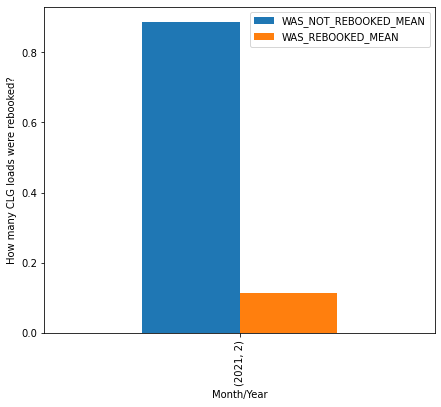

In [31]:
clg_rebookings = rebooking_stats_original[rebooking_stats_original.ORIGINAL_SYSTEM =='CLG']

clg_rebookings['WAS_NOT_REBOOKED_MEAN'] = 1.0 - clg_rebookings['WAS_REBOOKED_MEAN']

clg_rebooking_stats_pivot_table = pd.pivot_table(clg_rebookings[clg_rebookings.YEAR >= 2020], 
                                                      values = ['WAS_REBOOKED_MEAN', 'WAS_NOT_REBOOKED_MEAN'],
                                                     # columns = 'ORIGINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])

# Plot a bar chart using the DF
ax = clg_rebooking_stats_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("How many CLG loads were rebooked?")

<ipython-input-32-cd8e352bd915>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smart_rebookings['WAS_NOT_REBOOKED_MEAN'] = 1.0 - smart_rebookings['WAS_REBOOKED_MEAN']


Text(0, 0.5, 'How many SMART loads were rebooked?')

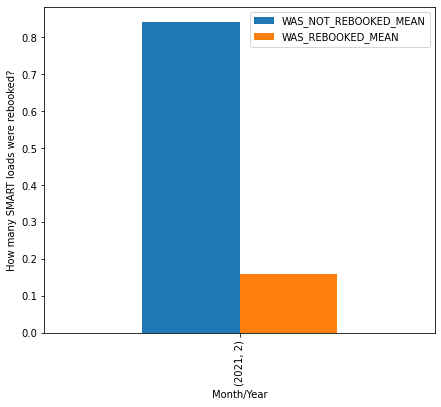

In [32]:
smart_rebookings = rebooking_stats_original[rebooking_stats_original.ORIGINAL_SYSTEM =='SMART']

smart_rebookings['WAS_NOT_REBOOKED_MEAN'] = 1.0 - smart_rebookings['WAS_REBOOKED_MEAN']

smart_rebooking_stats_pivot_table = pd.pivot_table(smart_rebookings[smart_rebookings.YEAR >= 2020], 
                                                      values = ['WAS_REBOOKED_MEAN', 'WAS_NOT_REBOOKED_MEAN'],
                                                     # columns = 'ORIGINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])

# Plot a bar chart using the DF
ax = smart_rebooking_stats_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("How many SMART loads were rebooked?")

In [33]:
smart_rebooking_stats_pivot_table.head()

,,WAS_NOT_REBOOKED_MEAN,WAS_REBOOKED_MEAN
YEAR,MONTH,,
2021,2,0.840391,0.159609


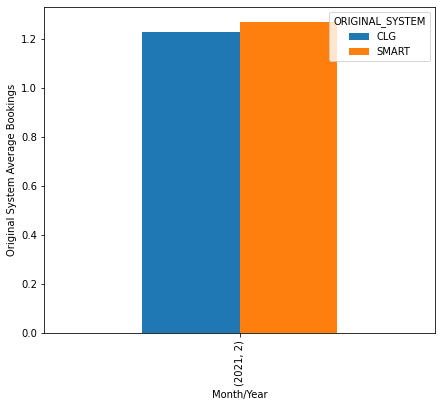

In [34]:
# not as impactful 
rebooking_stats_original_pivot_table = pd.pivot_table(rebooking_stats_original[rebooking_stats_original.YEAR >= 2020], 
                                                      values = 'TOTAL_BOOKINGS_MEAN',
                                                     columns = 'ORIGINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = rebooking_stats_original_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("Original System Average Bookings")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
import os 
# os.mkdir('subset')
fig.savefig("subset/average_bookings_original_system.png")

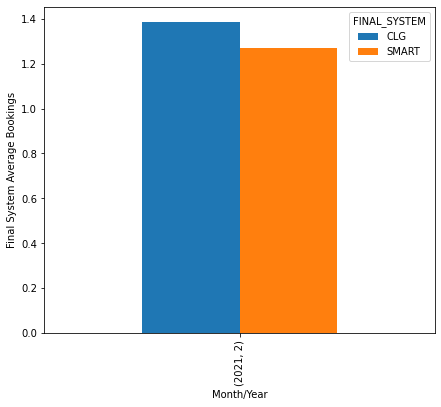

In [35]:
# not as impactful 
rebooking_stats_final_pivot_table = pd.pivot_table(rebooking_stats_final[rebooking_stats_final.YEAR >= 2020], 
                                                      values = 'TOTAL_BOOKINGS_MEAN',
                                                     columns = 'FINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = rebooking_stats_final_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("Final System Average Bookings")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("subset/average_bookings_final_system.png")

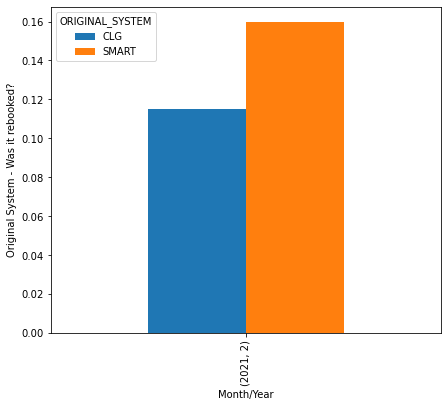

In [36]:
# REALLY IMPACTFUL 

rebooking_stats_original_pivot_table = pd.pivot_table(rebooking_stats_original[rebooking_stats_original.YEAR >= 2020], 
                                                      values = 'WAS_REBOOKED_MEAN',
                                                     columns = 'ORIGINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = rebooking_stats_original_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("Original System - Was it rebooked?")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("subset/was_rebooked_original_system.png")

Text(0, 0.5, 'subset/Original System Average Bookings')

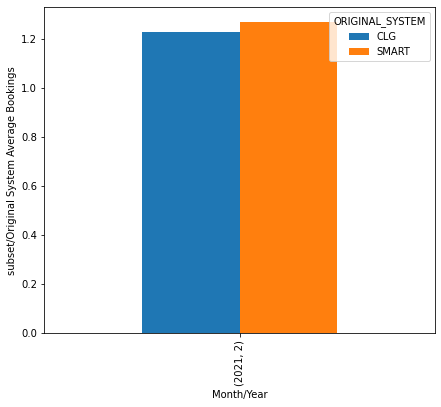

In [37]:
rebooking_stats_original_pivot_table = pd.pivot_table(rebooking_stats_original[rebooking_stats_original.YEAR >= 2020], 
                                                      values = 'TOTAL_BOOKINGS_MEAN',
                                                     columns = 'ORIGINAL_SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = rebooking_stats_original_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("subset/Original System Average Bookings")



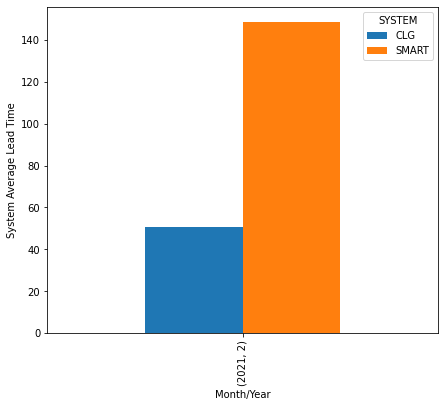

In [38]:
tour_metrics_pivot_table = pd.pivot_table(tour_metrics[(tour_metrics.YEAR >= 2020) & (tour_metrics.SYSTEM != 'RG')], 
                                                      values = 'LEAD_TIME_MEAN',
                                                     columns = 'SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = tour_metrics_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("System Average Lead Time")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("subset/average_lead_time_system.png")

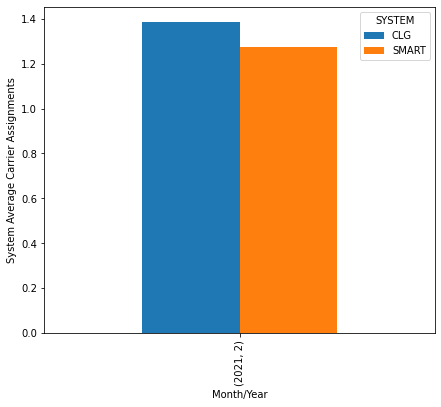

In [39]:
tour_metrics_pivot_table = pd.pivot_table(tour_metrics[(tour_metrics.YEAR >= 2020) & (tour_metrics.SYSTEM != 'RG')], 
                                                      values = 'CARRIER_ASSIGNMENTS_MEAN',
                                                     columns = 'SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = tour_metrics_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("System Average Carrier Assignments")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("subset/average_carrier_assignments_system.png")

Text(0, 0.5, 'CLG Raw Ranks')

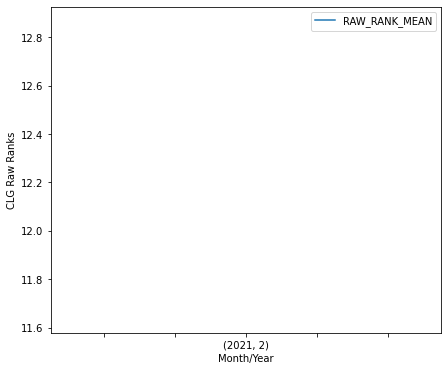

In [40]:
clg_rank_pivot_table = pd.pivot_table(clg_rank[(clg_rank.YEAR >= 2020)], 
                                                      values = 'RAW_RANK_MEAN',
                                                     # columns = 'SYSTEM',
                                                     index = ['YEAR', 'MONTH'])

# Plot a bar chart using the DF
ax = clg_rank_pivot_table.plot(kind="line")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("CLG Raw Ranks")

<ipython-input-41-25c06e648ca9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  clg_tours.describe(include = 'all')
<ipython-input-41-25c06e648ca9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  clg_tours.describe(include = 'all')
<ipython-input-41-25c06e648ca9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  clg_tours.describe(include = 'all')
<ipython-input-41-25c06e648ca9>:1: Futur

array([[<AxesSubplot:title={'center':'CARRIER_RANK'}>]], dtype=object)

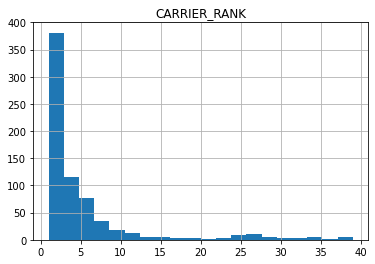

In [41]:
clg_tours.describe(include = 'all')

clg_tours[~(clg_tours.CARRIER_RANK.isna()) & (clg_tours.CARRIER_RANK <= 40)][['CARRIER_RANK']].hist(bins = 20)

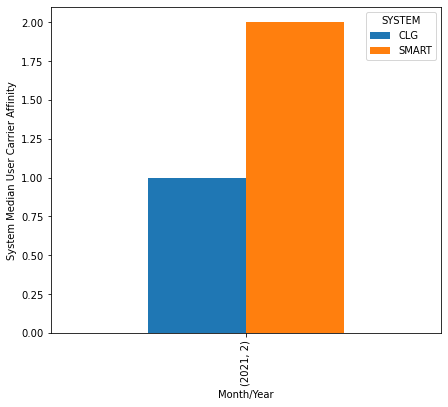

In [42]:
user_data_2 = pd.read_csv('processed_user_carrier_data.csv')

user_data_2_metrics = user_data_2.groupby(['YEAR', 'MONTH', 'SYSTEM'])[['TOTAL_TRIPS', 'TOTAL_TRIPS_2']].agg(['mean', 'median']).reset_index()

user_data_2_metrics.columns = ['YEAR', 'MONTH', 'SYSTEM', 'TOTAL_TRIPS_MEAN', 'TOTAL_TRIPS_MEDIAN', 'TOTAL_TRIPS_2_MEAN', 'TOTAL_TRIPS_2_MEDIAN']
user_data_2_metrics = user_data_2_metrics.reset_index(drop = True)

user_data_2_metrics_pivot_table = pd.pivot_table(user_data_2_metrics[(user_data_2_metrics.YEAR >= 2019) & (user_data_2_metrics.SYSTEM != 'RG')], 
                                                      values = 'TOTAL_TRIPS_2_MEDIAN',
                                                     columns = 'SYSTEM',
                                                     index = ['YEAR', 'MONTH'])



# Plot a bar chart using the DF
ax = user_data_2_metrics_pivot_table.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Month/Year")
ax.set_ylabel("System Median User Carrier Affinity")

# Use this to show the plot in a new window
# plt.show()
# Export the plot as a PNG file
fig.savefig("subset/median_user_carrier_affinity_system.png")

In [43]:
user_data_2_metrics

,YEAR,MONTH,SYSTEM,TOTAL_TRIPS_MEAN,TOTAL_TRIPS_MEDIAN,TOTAL_TRIPS_2_MEAN,TOTAL_TRIPS_2_MEDIAN
0,2021,2,CLG,7.668576,3.0,3.341783,1.0
1,2021,2,RG,2.640000,2.0,0.090047,0.0
2,2021,2,SMART,11.170284,6.0,4.681048,2.0


In [44]:
tour_rebookings_subset = tour_rebookings[(tour_rebookings.FINAL_DATE_ASSIGNED >= pd.to_datetime(start_date_time)) & (tour_rebookings.FINAL_DATE_ASSIGNED <= pd.to_datetime(end_date_time))]

In [45]:
tour_rebookings.describe(include = "all")

<ipython-input-45-1ebd675b6921>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tour_rebookings.describe(include = "all")
<ipython-input-45-1ebd675b6921>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tour_rebookings.describe(include = "all")


,SHIPMENT_ID,ORIGINAL_SYSTEM,ORIGINAL_DATE_ASSIGNED,FINAL_SYSTEM,FINAL_DATE_ASSIGNED,CLG_REBOOKINGS,SMART_REBOOKINGS,RG_REBOOKINGS,TOTAL_REBOOKINGS,MONTH,YEAR,WAS_REBOOKED,WAS_REBOOKED_IN_SMART,WAS_REBOOKED_IN_CLG,WAS_REBOOKED_IN_RG
count,2.083000e+03,2083,2083,2083,2083,2083.000000,2083.000000,2083.000000,2083.000000,2083.0,2083.0,2083.000000,2083.000000,2083.000000,2083.000000
unique,NaN,3,2077,3,2076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,CLG,2021-02-17 09:37:02,CLG,2021-02-15 10:52:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1155,2,1223,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2019-11-21 12:48:48,NaN,2021-02-15 05:13:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2021-02-21 20:30:07,NaN,2021-02-21 20:30:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.658544e+07,NaN,NaN,NaN,NaN,0.706193,0.424868,0.200672,1.331733,2.0,2021.0,0.174268,0.108017,0.097936,0.028325
std,2.136507e+04,NaN,NaN,NaN,NaN,0.712921,0.654913,0.571547,0.845901,0.0,0.0,0.379431,0.310477,0.297299,0.165938
min,1.575685e+07,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,2.0,2021.0,0.000000,0.000000,0.000000,0.000000
25%,1.658251e+07,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,2.0,2021.0,0.000000,0.000000,0.000000,0.000000


In [46]:
tours.describe(include = "all")

<ipython-input-46-591b064f06f7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tours.describe(include = "all")
<ipython-input-46-591b064f06f7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tours.describe(include = "all")
<ipython-input-46-591b064f06f7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  tours.describe(include = "all")
<ipython-input-46-591b064f06f7>:1: FutureWarning: Tr

,Column1,SEGMENT_NUMBER,CREATED_BY,CREATE_DATE,USER_ID,USER_ROLE,ACTION,CARRIER_SCORE,TOP_RANKED_CARRIER_SCORE,BOTTOM_RANKED_CARRIER_SCORE,CARRIER_RANK,TOTAL_CARRIERS_RANKED,SHIPMENT_ID,CLG_FG,RG_FG,ASSET_FG,TOUR_STATUS_TX,CARRIER_NM,ECP_CARRIER_IDENT,STAKEHOLDER_ID,CARRIER_ASSIGNED_BY,CARRIER_ASSIGNED_TS,LOAD_NEEDS_BROKERING_TS,TOTAL_CARRIER_ASSIGNMENTS,CARRIER_ASSIGNEE_GUID,ROUTING_GUIDE_ACTION_CREATE_TS,TENDER_STATUS_DESCRIPTION_TX,MONTH,YEAR,LEAD_TIME,TIME_DIFF_CLG,TIME_DIFF_RG,ACTUAL_SHIPMENT_ID,ACTUAL_CARRIER_ASSIGNED_TS,ACTUAL_TIME_DIFF,SYSTEM
count,2.083000e+03,1.201000e+03,1201,1201,1201,993,1201,769.000000,1191.000000,1191.000000,769.000000,1191.000000,2.083000e+03,2083.000000,2083.000000,2083.0,2083,2083,2.080000e+03,2.083000e+03,2083,2083,1108,2083.000000,1839,228,228,2083.0,2083.0,1108.000000,1.201000e+03,2.280000e+02,2.083000e+03,2083,2083.000000,2083
unique,NaN,NaN,55,1201,55,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,697,NaN,NaN,95,2076,1107,NaN,74,228,1,NaN,NaN,NaN,NaN,NaN,NaN,2080,NaN,3
top,NaN,NaN,"Baker, Gregory",2021-02-19 14:26:19.000000983,4109631a-e716-4c99-980b-7a87f92197b6,CLG-EXP-2,CARRIER_ASSIGNMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Completed (Delivered),AC TRUCKING,NaN,NaN,jboss,2021-02-15 10:52:28,2021-02-20 11:37:37,NaN,4109631A-E716-4C99-980B-7A87F92197B6,2021-02-18 08:07:57.000000371,Accepted,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-17 09:37:02,NaN,CLG
freq,NaN,NaN,139,1,139,993,1201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2054,87,NaN,NaN,211,2,2,NaN,153,1,228,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,1223
first,NaN,NaN,NaN,2019-11-21 12:48:55.000000371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-15 05:13:42,2019-11-20 11:34:15,NaN,NaN,2021-01-29 08:36:34.000000910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-15 05:13:42,NaN,NaN
last,NaN,NaN,NaN,2021-02-21 20:30:20.000000960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-21 20:30:07,2021-02-21 20:08:44,NaN,NaN,2021-02-20 08:42:05.000000174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-21 20:30:20.000000960,NaN,NaN
mean,1.006793e+06,1.658332e+07,NaN,NaN,NaN,NaN,NaN,9.218165,9.329707,8.078277,12.252276,102.324937,1.658544e+07,0.553529,0.109458,0.0,NaN,NaN,1.000232e+08,1.714772e+06,NaN,NaN,NaN,1.334133,NaN,NaN,NaN,2.0,2021.0,57.966409,6.188432e+04,6.800328e+04,1.658544e+07,NaN,-5.897944,NaN
std,6.021563e+03,2.710334e+04,NaN,NaN,NaN,NaN,NaN,0.329455,0.242293,0.234281,28.680147,101.373514,2.136507e+04,0.497246,0.312287,0.0,NaN,NaN,1.907277e+04,5.679074e+05,NaN,NaN,NaN,0.850338,NaN,NaN,NaN,0.0,0.0,339.894192,1.155714e+06,2.780586e+05,2.136507e+04,NaN,9.401681,NaN
min,7.562250e+05,1.575685e+07,NaN,NaN,NaN,NaN,NaN,7.472600,7.968700,7.393500,1.000000,1.000000,1.575685e+07,0.000000,0.000000,0.0,NaN,NaN,1.000000e+08,2.716000e+03,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,-2.375833,-1.494460e+02,-6.900000e-01,1.575685e+07,NaN,-149.446000,NaN
25%,1.006548e+06,1.657985e+07,NaN,NaN,NaN,NaN,NaN,9.144900,9.337500,7.986000,1.000000,31.000000,1.658251e+07,0.000000,0.000000,0.0,NaN,NaN,1.000052e+08,1.745541e+06,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,2.0,2021.0,0.844653,-1.411200e+01,1.405000e-01,1.658251e+07,NaN,-11.776000,NaN
